# CPF Practice Project 01

by D. Osin

09-05-2025

## Asset Management Practice Project

#### The first asset management practice project is about reviewing the core MVP model and implementing it in a class-based setup.

### The task is:

#### 1. Implement from scratch the Mean-Variance Portfolio (MVP) model as a Python class.
####    Include optimization methods to derive the minimum variance portfolio as well as the maximum Sharpe portfolio.

#### 2. Implement from scratch as a Python class a rolling backtesting approach for the Mean-Variance Portfolio model.
####    This class can inherit from the first class.
####    The idea is to allow the user to define the look-back period (say, 1 or 2 years),
####    from which data is used to derive the MVP optimal portfolio.
####    Then the optimal portfolio's performance for the next period (e.g. one week when working with weekly data) is calculated.
####    The weekly out-of-sample performances shall be aggregated and presented at the end as the total performance
####    over the total out-of-sample backtesting period (for example, 52 weeks = 1 year).
####    The performance shall also be presented as an annualized return.

#### Make use of the following data set:

https://hilpisch.com/indices_eikon_eod_data.csv

In [6]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize
from pylab import plt
import cufflinks
import warnings
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8')
cufflinks.set_config_file(offline=True)
np.set_printoptions(suppress=True, precision=4)
pd.options.display.float_format = '{:.4f}'.format
%config InlineBackend.figure_format = 'svg'

## Step 1
### Define Financial Data (FD) class, which will read the data set provided in the link above.
### It will prepare the data for the MVP class. It can also plot the data.

In [8]:
class FD:
    '''
    This class reads a real financial data set from the web link.
    Input data set is called here - universe.
    universe can be either the entire list of assets in the raw data
    or it can be limited by the user to the desired assets.
    It produces price returns.
    This class allows the user to plot data, returns and a correlation matrix for the used assets.
    Class Methods:
    __init__()
    get_data()
    prep_rets()
    plot_data()
    plot_rets()
    '''
    
    url = 'http://hilpisch.com/indices_eikon_eod_data.csv'
    
    def __init__(self, universe):
        self.universe = universe
        self.noa = len(universe)
        self.get_data()
        self.prep_rets()

    def get_data(self):
        self.raw = pd.read_csv(self.url, index_col=0).dropna()
        if self.universe is None:
            self.universe = self.raw.columns
        elif len(self.universe) == 0:
            self.universe = self.raw.columns
        self.data = self.raw[self.universe]

    def prep_rets(self):
        self.rets = self.data.pct_change().dropna()
        # self.rets = np.log(self.rets) log of returns produces huge amount of NaN
        
    def plot_data(self, cols=None):
        if cols is None:
            cols = self.universe
        self.data[cols].normalize().iplot()
    
    def plot_rets(self, cols=None):
        if cols is None:
            cols = self.universe
        self.rets[cols].iplot()
        
    def plot_corr(self):
        self.rets.corr().iplot(kind='heatmap', colorscale='ylorrd') # ylgnbu, bupu, ylorrd

To prepare data for further analysis we run the following command

In [10]:
fd = FD(universe=[])

To check that data was read and prepeared we can plot it.

We can also have a look at returns and correlation between the assets.

In [12]:
fd.plot_data()

In [13]:
fd.plot_rets()

In [14]:
fd.plot_corr()

## Step 2

### Define Mean-Variance Portfolio (MVP) class.
### This class provides the user with methods to construct a portfolio with either minimum variance or maximum Sharpe ratio.

In [16]:
class MVP(FD):
    '''
    Class Mean-Variance Portfolio (MVP) provides methods to construct a asset portfolio
    with either a minimum variance or a maximum Sharpe ratio.
    Portfolio is based on an input set of assets - called here universe.
    By default equal weights are asigned to assets.
    These weights are optimised for a chosen type of portfolio.
    Weights can be visualized.
    Class methods:
    __init__()
    p_return()
    p_variance()
    p_volatility()
    p_Sharpe()
    w_bounds()
    w_constraints()
    p_min_vol()
    p_max_sr()
    p_stat()
    plot_weights()
    '''
    def __init__(self, universe):
        '''initializes universe of assets and gives them equal weights.'''
        super().__init__(universe)
        self.eqw = self.noa * [1 / self.noa]

    def p_return(self, weights, days=252):
        """
        Computes the annualized return on a portfolio from assets' returns and weights.
        """
        return np.dot(self.rets.mean(), weights) * days

    def p_variance(self, weights, days=252):
        """
        Computes the annualized variance of a portfolio from the asset returns covariance matrix and weights.
        """
        return np.dot(weights, np.dot(self.rets.cov(), weights)) * days
         
    def p_volatility(self, weights, days=252):
        return np.sqrt(self.p_variance(weights, days))    

    def p_Sharpe(self, weights, days=252):
        """
        Computes the annualized sharpe ratio of a set of returns
        """
        sr = (self.p_return(weights, days) / self.p_volatility(weights, days))
        return sr

    def w_bounds(self, bounds):
        '''Defines bounds for the asset weights for the optimization process'''
        if bounds is None:
            self.bounds = self.noa * [(0, 1)]
        else:
            self.bounds = bounds
        
    def w_constraints(self, constr):
        '''Defines constraints for the asset weights for the optimization process.
           In this case the sum of all weights must be equal to 1.'''
        if constr is None:
            self.constr = {'type': 'eq', 'fun': lambda weights: weights.sum() - 1}
        else:
            self.constr = constr

    def p_min_vol(self, bounds=None, constr=None):
        '''
        Optimizes weights of assets to produce a portfoliio with minimum volatility.
        Uses bounds and constraints on weights provided by the user.
        '''
        self.w_bounds(bounds)
        self.w_constraints(constr)
        optw = minimize(self.p_volatility, self.eqw,
                       bounds=self.bounds, constraints=self.constr)
        self.p_status = self.p_stat(optw, 'Minimum Volatility')
        return self.p_status
        
    def p_max_sr(self, bounds=None, constr=None):
        '''
        Optimizes weights of assets to produce a portfolio with maximum Sharpe ratio.
        Uses bounds and constraints on weights provided by the user.
        Minimizes negative Sharpe ratio.
        '''
        self.w_bounds(bounds)
        self.w_constraints(constr)
        sr_ = lambda weights: -self.p_Sharpe(weights)
        optw = minimize(sr_, self.eqw,
                        bounds=self.bounds, constraints=self.constr)
        self.p_status = self.p_stat(optw, 'Maximum Sharpe')
        return self.p_status

    def p_stat(self, optw, kind):
        '''
        Contains current status and statistics of the asset portfolio.
        Allows one to analyse the portfolio performance.
        '''
        ret = self.p_return(optw.x)
        vol = self.p_volatility(optw.x)
        sr = self.p_Sharpe(optw.x)
        pw = optw.x
        p_status = pd.DataFrame({'kind': kind, 'weights': pw.round(3), 'return': ret,
                    'volatility': vol, 'Sharpe_ratio': sr}, index=self.universe)
        return p_status

    def plot_weights(self):
        '''
        Plot optimized weights.
        '''
        self.p_status['weights'].iplot(kind='bar', 
                    title=self.p_status['kind'][0] + ' Portfolio Weights')

Initiate the MVP class with the universe of assets

In [18]:
mvp = MVP(fd.universe)

Look at the portfolio return in the case of equal weights for essets

In [20]:
mvp.p_return(mvp.eqw)

0.11125051791783229

Look at the variance of the portfolio with equal weights

In [22]:
mvp.p_variance(mvp.eqw)

0.0234678971575874

Calculate the Sharpe ratio for the equal weights portfolio

In [24]:
mvp.p_Sharpe(mvp.eqw)

0.7262145623300525

Create portfolio with Minimum Volatility

and look at the portfolio statistics

In [26]:
mvp.p_min_vol()

,kind,weights,return,volatility,Sharpe_ratio
.FCHI,Minimum Volatility,0.0000,0.0893,0.1403,0.6367
.FTSE,Minimum Volatility,0.1910,0.0893,0.1403,0.6367
.GDAXI,Minimum Volatility,0.0000,0.0893,0.1403,0.6367
.HSI,Minimum Volatility,0.0240,0.0893,0.1403,0.6367
.NDX,Minimum Volatility,0.0000,0.0893,0.1403,0.6367
.NSEI,Minimum Volatility,0.2170,0.0893,0.1403,0.6367
.SPX,Minimum Volatility,0.2330,0.0893,0.1403,0.6367
.SSEC,Minimum Volatility,0.3350,0.0893,0.1403,0.6367


Plot weights of the assets for this portfoion

In [28]:
mvp.plot_weights()

Create portfolio with the Maximum Sharpe Ratio

and look athe portfolio statistics

In [30]:
mvp.p_max_sr(bounds=mvp.noa * [(0.05, 0.6)])

,kind,weights,return,volatility,Sharpe_ratio
.FCHI,Maximum Sharpe,0.0500,0.1914,0.1701,1.1254
.FTSE,Maximum Sharpe,0.0500,0.1914,0.1701,1.1254
.GDAXI,Maximum Sharpe,0.0500,0.1914,0.1701,1.1254
.HSI,Maximum Sharpe,0.0500,0.1914,0.1701,1.1254
.NDX,Maximum Sharpe,0.5150,0.1914,0.1701,1.1254
.NSEI,Maximum Sharpe,0.1850,0.1914,0.1701,1.1254
.SPX,Maximum Sharpe,0.0500,0.1914,0.1701,1.1254
.SSEC,Maximum Sharpe,0.0500,0.1914,0.1701,1.1254


After the optimal portfolio was creted, we can look at the status and its statistics in the following way

In [32]:
mvp.p_status

,kind,weights,return,volatility,Sharpe_ratio
.FCHI,Maximum Sharpe,0.0500,0.1914,0.1701,1.1254
.FTSE,Maximum Sharpe,0.0500,0.1914,0.1701,1.1254
.GDAXI,Maximum Sharpe,0.0500,0.1914,0.1701,1.1254
.HSI,Maximum Sharpe,0.0500,0.1914,0.1701,1.1254
.NDX,Maximum Sharpe,0.5150,0.1914,0.1701,1.1254
.NSEI,Maximum Sharpe,0.1850,0.1914,0.1701,1.1254
.SPX,Maximum Sharpe,0.0500,0.1914,0.1701,1.1254
.SSEC,Maximum Sharpe,0.0500,0.1914,0.1701,1.1254


Plot weights of the Minimum Volatility portfolio

In [34]:
mvp.plot_weights()

## Step 3
### Perform rolling backtesting for the Mean-Variance Portfolio model.
### The user can choose the look-back period (e.g., 252 days) for which the MVP is optimized.
### The optimized portfolio weights are then used to calculate performance of this portfolio during the next period of time, out-of-sample period, (e.g., 30 days).
### Both the in-sample and the out-of-sample performances are stored and can be printed or plotted to see the performance over the total backtesting period.
### The following statistics is calculated: asset weights, annualized return, volatility, Sharpe ratio.

## Walk Forward Optimization (WFO)

### For the rolling backtesting we are going to use WFO.
### Traditional backtesting is limited by its static nature and susceptibility to overfitting, making it an unreliable predictor of future performance. WFO offers a more adaptive alternative, continually reassessing strategy parameters through a rolling-window approach.
### Walk-forward optimization yields valuable information regarding the robustness of a trading strategy and permits testing of how a strategy adapts to current market conditions by allowing the retraining of a model or recalibrating the parameters of the indicators used.
### A walk-forward optimization forces us to verify that we are adjusting our strategy parameters to signals in the past by constantly testing our optimized parameters with out-of-sample data.
### Out-of-sample testing refers to the process of splitting the data and saving one part to use as validation once the strategy is ready. As such, the testing is carried out only on a portion of the data and not on its entirety. The portion of the data used for initial testing is called in-sample data; the other part, used for validation, is called out-of-sample. By validating performance across multiple out-of-sample periods, WFO better simulates real-world trading.
### The rationale behind out-of-sample testing is that random patterns won’t persist through both data sets because any strategy that was curve fit should fall apart once we test on the new random data. Walk-forward optimization allows our strategy to adapt to prevailing market conditions through periodic optimizations.

#### In the example below, these optimizations occur yearly. Having multiple optimizations also gives a glimpse into the strategy’s parameter stability.

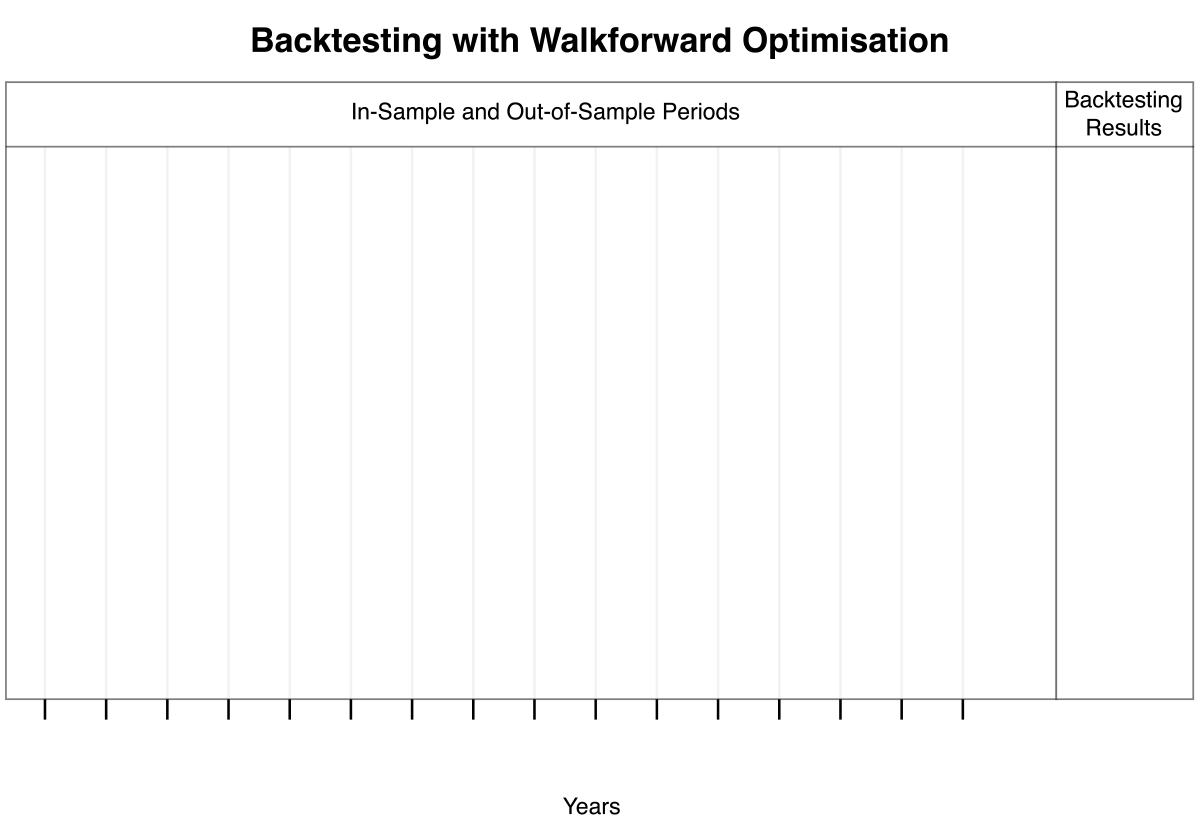

## WFO Process
### 1. Get All the Relevant Data
### 2. Break Data Into Multiple Windows
### 3. Run the Optimization to Find the Best Parameters on the First Window of the Data
### 4. Apply Those Parameters to the Out-of-Sample Data
### 5. Iterate until all the data is used

## WFO Considerations
### 1. Number of runs - The more runs we make the longer the test will be. However, with a larger number of iterations, we can have increased confidence that our model is capturing some signal in the data and not just replicating the in-sample noise.
### 2. Window Size - Too short an in-sample window misses essential market cycles and produces unstable parameters, while too long a window incorporates outdated market conditions that may no longer be relevant. Even the specific starting points of the windows can capture seasonal effects or unique market periods that skew results, creating another source of potential bias in the testing framework.

#### As a rule of thumb, it is recommended to set these meta-parameters as follows:

* Number of Runs: between 10 and 30
* Out-of-Sample Percentage: between 10% and 40%


In [41]:
class RBT(MVP):
    '''
    Class Rolling Backtesting (RBT) provides methods to assess performance of the Mean-Variance Portfolio (MVP) class.
    RBT is backtesting both Minimum Volatility and Maximum Sharpe Portfolios using a Walk Forward Optimizasion (FWO) technique.
    FWO technique uses in-sample data, defined by the lookback period, to optimize portfolios and produce the optimal weights for the 
    portfolio assets. These weights are then applied to the out-of-sample data, defined by the out-of-sample period, to check the
    performance of the optimized portfolio. In the next iteration, the time for the lookback period is shifted by the out-of-sample
    period and portfolio is optimized for the new lookback period, which now includes the previous out-of-sample period.
    The new optimal weights are tested on the new out-of-sample period this time. The WFO is repeated until the end of the data set
    time window is reached. This WFO approach is called unanchored, which allows the parameters to adapt faster to current conditions,
    and it is more suitable for short-term strategies or if the market has a changing behavior.
    Class methods:
    __init__()
    rbt_stats()
    plot_rbt_stats()
    plot_rbt_cum_ret()
    '''
    def __init__(self, universe, lookback=None, outos=None):
        '''
        Initializes universe of assets, lookback and out-of-sample periods.
        '''
        super().__init__(universe)
        self.lookback = lookback
        self.outos = outos
        if lookback is None:
            self.lookback = int(252)
        else:
            self.lookback = int(lookback)
        if outos is None:
            self.outos = int(30)
        elif self.outos > self.lookback:
            print('Lookback period must be longer than out-of-sample period.\n'
                  'It is practical to set the duration of the out-of-sample period\n'
                  'to be 0.1 to 0.2 of the lookback duration (e.g., 252 days and 30 days)\n'
                  'Duration of out-of-sample period will be set to 0.1 of lookback period.')
            self.outos = int(0.1*self.lookback)
        else:
            self.outos = int(outos)

    def rbt_stats(self, p_kind=None, bounds=None, constr=None):
        '''
        Perform rolling bactesting on a portfolio of a choice Minimum Volatility or Maximum Sharpe Ratio
        with the given assets. Rolling backtesting is done using unanchored Walk Forward Optimization technique (WFO).
        WFO is the process of testing a trading strategy by finding its optimal parameters during a specific period,
        referred to as the “in-sample” dataset, and checking the performance of those parameters in the following period,
        which is called the “out-of-sample” dataset. Subsequently, both the in and out of sample datasets are moved forward, 
        and the analysis is repeated with a new set of price data. Once we complete all iterations,
        the recorded results are analyzed to assess the strategy performance.
        Three input parameters are:
        p_kind - "Minimum Volatility", "Maximum Sharpe"
        bounds - asset weight bounds for the portfolio optimization process
                 the size is 1-d list (num1, num2)*len(number of asssets), where num1 < num2
                 numbers can be from -inf to inf if we are allowed to sell an asset
        constr - constraints on the asset weights for the porrtfolio optimization process
                 In this case the sum of all weights must be equal to 1.                 
        '''             
        if p_kind == 'Minimum Volatility':
            print('Rolling Backtesting for Portfolio', p_kind)
        elif p_kind == 'Maximum Sharpe':
            print('Rolling Backtesting for Portfolio', p_kind)
        else:
            p_kind = 'Maximum Sharpe'
            print('Rolling Backtesting for Portfolio', p_kind)
        
        self.ins_min_vol_stat = pd.DataFrame()
        self.oos_min_vol_stat = pd.DataFrame()
        self.ins_max_sr_stat = pd.DataFrame()
        self.oos_max_sr_stat = pd.DataFrame()
        self.ins_rets = pd.DataFrame()
        self.oos_rets = pd.DataFrame()
        for i in range(0, len(self.data), self.outos):
            if (i + self.lookback + self.outos) <= len(self.data):
                ins_data = self.data.loc[self.data.index[i:i + self.lookback]]
                oos_data = self.data.loc[self.data.index[i + self.lookback:i + self.lookback + self.outos]]
                ins_rets_ = ins_data.pct_change().dropna()
                oos_rets_ = oos_data.pct_change().dropna()
                self.ins_rets = pd.concat([self.ins_rets, ins_rets_])
                self.oos_rets = pd.concat([self.oos_rets, oos_rets_])
                # returns become in-sample returns so it is possible to use on them functions from MVP
                self.rets = ins_rets_
                if p_kind == 'Minimum Volatility':
                    ins_stat = self.p_min_vol(bounds, constr).reset_index()
                    ins_stat = ins_stat.rename(columns={'index':'asset'})
                    ins_stat['ins_period'] = int(i / self.outos)
                    ins_stat = ins_stat.set_index('ins_period')
                    self.ins_min_vol_stat = pd.concat([self.ins_min_vol_stat, ins_stat])
                    # Now it is time to deal with the out-of-sample data
                    # returns become out-of-sample returns so it is possible to use on them functions from MVP
                    self.rets = oos_rets_
                    # apply to the out-of-sample data weights optimized on the in-sample data
                    oos_p_ret = self.p_return(weights=list(ins_stat['weights']), days=self.outos)
                    oos_p_vol = self.p_volatility(weights=list(ins_stat['weights']), days=self.outos)
                    oos_p_sr = self.p_Sharpe(weights=list(ins_stat['weights']), days=self.outos)
                    oos_stat = pd.DataFrame({'kind': self.p_status['kind'],
                                             'weights': list(ins_stat['weights']),
                                             'return': oos_p_ret,
                                             'volatility': oos_p_vol,
                                             'Sharpe_ratio': oos_p_sr},
                                            index=list(self.universe))
                    oos_stat = oos_stat.reset_index()
                    oos_stat = oos_stat.rename(columns={'index':'asset'})
                    oos_stat['oos_period'] = int(i / self.outos)
                    oos_stat = oos_stat.set_index('oos_period')
                    self.oos_min_vol_stat = pd.concat([self.oos_min_vol_stat, oos_stat])
                else:
                    ins_stat = self.p_max_sr(bounds, constr).reset_index()
                    ins_stat = ins_stat.rename(columns={'index':'asset'})
                    ins_stat['ins_period'] = int(i / self.outos)
                    ins_stat = ins_stat.set_index('ins_period')
                    self.ins_max_sr_stat = pd.concat([self.ins_max_sr_stat, ins_stat])
                    
                    # Now it is time to deal with the out-of-sample data
                    # returns become out-of-sample returns so it is possible to use on them functions from MVP
                    self.rets = oos_rets_
                    # apply to the out-of-sample data weights optimized on the in-sample data
                    oos_p_ret = self.p_return(weights=list(ins_stat['weights']), days=self.outos)
                    oos_p_vol = self.p_volatility(weights=list(ins_stat['weights']), days=self.outos)
                    oos_p_sr = self.p_Sharpe(weights=list(ins_stat['weights']), days=self.outos)
                    oos_stat = pd.DataFrame({'kind': self.p_status['kind'],
                                             'weights': list(ins_stat['weights']),
                                             'return': oos_p_ret,
                                             'volatility': oos_p_vol,
                                             'Sharpe_ratio': oos_p_sr},
                                            index=list(self.universe))
                    oos_stat = oos_stat.reset_index()
                    oos_stat = oos_stat.rename(columns={'index':'asset'})
                    oos_stat['oos_period'] = int(i / self.outos)
                    oos_stat = oos_stat.set_index('oos_period')
                    self.oos_max_sr_stat = pd.concat([self.oos_max_sr_stat, oos_stat])
                
            else:
                pass

    def plot_rbt_stats(self, toplot=None, p_kind=None, s_kind=None):
        '''
        Plot specified statistics of optimized portfolio during rolling backtesting.
        Takes three input parameters str type to specify Parameter, Portfolio and Sample kinds:
        toplot - 'ret', 'weights', 'vol', 'sr',
        p_kind - 'Minimum Volatility' or 'Maximum Sharpe'
        s_kind - 'ins' or 'oos'
        '''
        if toplot == 'ret':
            param = 'return'
            plot_kind = 'line'
            y_title = 'Portfolio Return'
        elif toplot == 'weights':
            param = 'weights'
            plot_kind = 'bar'
            y_title = 'Portfolio Weights'
        elif toplot == 'vol':
            param = 'volatility'
            plot_kind = 'line'
            y_title = 'Portfolio Volatility'
        elif toplot == 'sr':
            param = 'Sharpe_ratio'
            plot_kind = 'line'
            y_title = 'Portfolio Sharpe Ratio'
        else:
            print('To Plot Portfolio Statistics - Specify what Parameter to Plot:\
                  "ret", "weights", "vol", "sr" ')
        if p_kind == 'Minimum Volatility':
            if s_kind == 'ins':
                self.ins_min_vol_stat[param].iplot(kind=plot_kind, sortbars=True, theme="pearl",
                                                      # barmode='stack', 
                                                      xTitle='Sample Period Number', yTitle=y_title)
            elif s_kind == 'oos':
                self.oos_min_vol_stat[param].iplot(kind=plot_kind, sortbars=True, theme="pearl",
                                                      # barmode='stack', 
                                                      xTitle='Sample Period Number', yTitle=y_title)
            else:
                print('To Plot Portfolio Statistics - Specify Sample Kind: "ins" or "oos"')
        elif p_kind == 'Maximum Sharpe':
            if s_kind == 'ins':
                self.ins_max_sr_stat[param].iplot(kind=plot_kind, sortbars=True, theme="pearl",
                                                      # barmode='stack', 
                                                      xTitle='Sample Period Number', yTitle=y_title)
            elif s_kind == 'oos':
                self.oos_max_sr_stat[param].iplot(kind=plot_kind, sortbars=True, theme="pearl",
                                                      # barmode='stack', 
                                                      xTitle='Sample Period Number', yTitle=y_title)
            else:
                print('To Plot Portfolio Statistics - Specify Sample Kind: "ins" or "oos"')
        else:
            print('To Plot Portfolio Statistics - Specify Portfolio Kind: "Minimum Volatility" or "Maximum Sharpe"')
            
    def plot_rbt_cum_ret(self, toplot='cum_ret', p_kind=None, s_kind=None):
        '''
        Plot cumulative returns for optimized portfolios during the rolling backtesting.
        Takes three input parameters str type to specify Parameter, Portfolio and Sample kinds:
        toplot - 'cum_ret'
        p_kind - 'Minimum Volatility' or 'Maximum Sharpe'
        s_kind - 'ins' or 'oos'
        '''
        if toplot == 'cum_ret':
            if p_kind == 'Minimum Volatility':
                if s_kind == 'ins':
                    self.ins_min_vol_stat['return'].cumsum().iplot(kind='line',
                                                                   xTitle='Sample Period Number', yTitle='Portfolio Cumulative Return')
                elif s_kind == 'oos':
                    self.oos_min_vol_stat['return'].cumsum().iplot(kind='line',
                                                                   xTitle='Sample Period Number', yTitle='Portfolio Cumulative Return')
                else:
                    print('To Plot Weights - Specify Sample Kind: "ins" or "oos"')
            elif p_kind == 'Maximum Sharpe':
                if s_kind == 'ins':
                    self.ins_max_sr_stat['return'].cumsum().iplot(kind='line',
                                                                  xTitle='Sample Period Number', yTitle='Portfolio Cumulative Return')
                elif s_kind == 'oos':
                    self.oos_max_sr_stat['return'].cumsum().iplot(kind='line',
                                                                  xTitle='Sample Period Number', yTitle='Portfolio Cumulative Return')
                else:
                    print('To Plot Weights - Specify Sample Kind: "ins" or "oos"')
            else:
                print('To Plot Weights - Specify Portfolio Kind: "Minimum Volatility" or "Maximum Sharpe"')
        else:
            print('To Plot Portfolio Cumulative Return - Use toplot="cum_ret"')
    

Initiate rolling backtesting clas with the desired in-sample ('lookback') and out-of-sample ('outos') parameters

In [43]:
rbt = RBT(mvp.universe, lookback=252, outos=50)

Perform rolling backtesting for the Maximum Sharpe portfolio with bounds on weights: minimum weight = 5% and maximum wweight = 60%.

Constraints on weights are set to default - all weights should sum up to 100%.

In [45]:
rbt.rbt_stats(p_kind='Maximum Sharpe', bounds=mvp.noa * [(0.05, 0.6)], constr=None)

Rolling Backtesting for Portfolio Maximum Sharpe


Display statistics for the Maximum Sharpe Ratio portfolio for the out-of-sample data ('oos') and 'ins' for the in-sample data

In [47]:
rbt.oos_max_sr_stat

,asset,kind,weights,return,volatility,Sharpe_ratio
oos_period,,,,,,
0,.FCHI,Maximum Sharpe,0.0500,0.0371,0.0273,1.3585
0,.FTSE,Maximum Sharpe,0.1600,0.0371,0.0273,1.3585
0,.GDAXI,Maximum Sharpe,0.0500,0.0371,0.0273,1.3585
0,.HSI,Maximum Sharpe,0.0500,0.0371,0.0273,1.3585
0,.NDX,Maximum Sharpe,0.0500,0.0371,0.0273,1.3585
...,...,...,...,...,...,...
15,.HSI,Maximum Sharpe,0.0500,0.0592,0.1032,0.5743
15,.NDX,Maximum Sharpe,0.6000,0.0592,0.1032,0.5743
15,.NSEI,Maximum Sharpe,0.0500,0.0592,0.1032,0.5743


Plot weights for Maximum Sharpe Ratio portfolio (The weights for oos and ins are the same for the same iteration)

In [49]:
rbt.plot_rbt_stats(toplot='weights', p_kind='Maximum Sharpe', s_kind='ins')

Plot volatility ('vol'), Sharpe ratio ('sr') for bot ins and oos data.

In [51]:
rbt.plot_rbt_stats(toplot='vol', p_kind='Maximum Sharpe', s_kind='ins')

In [52]:
rbt.plot_rbt_stats(toplot='vol', p_kind='Maximum Sharpe', s_kind='oos')

In [53]:
rbt.plot_rbt_stats(toplot='sr', p_kind='Maximum Sharpe', s_kind='ins')

In [54]:
rbt.plot_rbt_stats(toplot='sr', p_kind='Maximum Sharpe', s_kind='oos')

Plot annualized (cummulative here) returns for both ins and oos data.

In [56]:
rbt.plot_rbt_cum_ret(toplot='cum_ret', p_kind='Maximum Sharpe', s_kind='ins')

In [57]:
rbt.plot_rbt_cum_ret(toplot='cum_ret', p_kind='Maximum Sharpe', s_kind='oos')

Run rolling backtesing for the Minimum Volatility portfolio with the same bounds and default constraints for asset weights.

In [59]:
rbt.rbt_stats('Minimum Volatility', bounds=mvp.noa * [(0.05, 0.6)], constr=None)

Rolling Backtesting for Portfolio Minimum Volatility


Print statistics of the Minimum Volatility portfolio (with different name of RBT class variable)

In [61]:
rbt.oos_min_vol_stat

,asset,kind,weights,return,volatility,Sharpe_ratio
oos_period,,,,,,
0,.FCHI,Minimum Volatility,0.0500,0.0341,0.0254,1.3449
0,.FTSE,Minimum Volatility,0.0500,0.0341,0.0254,1.3449
0,.GDAXI,Minimum Volatility,0.0500,0.0341,0.0254,1.3449
0,.HSI,Minimum Volatility,0.0500,0.0341,0.0254,1.3449
0,.NDX,Minimum Volatility,0.0500,0.0341,0.0254,1.3449
...,...,...,...,...,...,...
15,.HSI,Minimum Volatility,0.0710,0.0077,0.0637,0.1210
15,.NDX,Minimum Volatility,0.0710,0.0077,0.0637,0.1210
15,.NSEI,Minimum Volatility,0.0570,0.0077,0.0637,0.1210


Plot weights for this portfolio

In [63]:
rbt.plot_rbt_stats(toplot='weights', p_kind='Minimum Volatility', s_kind='ins')

Plot volatility and Sharpe ratio for both ins and oos data

In [65]:
rbt.plot_rbt_stats(toplot='vol', p_kind='Minimum Volatility', s_kind='ins')

In [66]:
rbt.plot_rbt_stats(toplot='vol', p_kind='Minimum Volatility', s_kind='oos')

In [67]:
rbt.plot_rbt_stats(toplot='sr', p_kind='Minimum Volatility', s_kind='ins')

In [68]:
rbt.plot_rbt_stats(toplot='sr', p_kind='Minimum Volatility', s_kind='oos')

Plot annualized returns for both ins and oos data

In [70]:
rbt.plot_rbt_cum_ret(toplot='cum_ret', p_kind='Minimum Volatility', s_kind='ins')

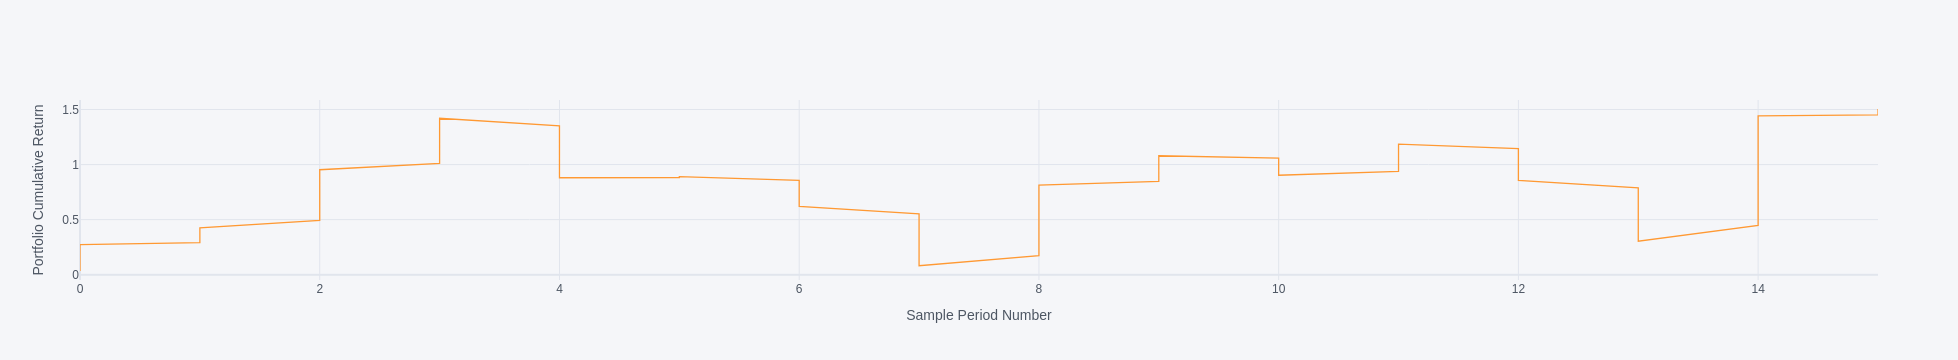

In [71]:
rbt.plot_rbt_cum_ret(toplot='cum_ret', p_kind='Minimum Volatility', s_kind='oos')

## Conclusion:
### The classes defined in this project allow us to read the given data and perform portfolio analysis.
### This is what we can do in the analysis:

* Choose the assets that would constitute the universe.
* Optimize weights to construct either Minimum Volatility or Maximum Sharpe Ratio portfolio.
* Perform a rolling becktesting on the chosen portfolio using a Walk Forward Optimization technique.
* Change in-sample and out-of-sample duration
* Print and plot portfolio statistics

## Notes on the Project
1. The project was very interesting and it was a big satisfaction for me to see it running properly.
2. I realised that I need to spend more time with pandas datetime function.
3. I was not able to produce a better bar chart for portfolio weights.
4. I enjoyed working independently. This was real fun to do small researches during the project.
5. It would be nice to try working with significantly larger number of assets than eight.